<a href="https://colab.research.google.com/github/harvard-visionlab/sroh/blob/main/2022/face_processing_deepnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads and imports (only need to do these once at the start)

In [1]:
!wget -c -q https://raw.githubusercontent.com/harvard-visionlab/sroh/main/2022/feature_extractor.py

In [2]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [86]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.0 MB/s 


In [126]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ms4ljm0e
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ms4ljm0e
     |████████████████████████████████| 48.3 MB 2.1 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=113560 sha256=921f1c335fa66fea6d9ab5dbd8b2dc8d6c6d337e98f2ff49dac16fa78c232262
  Stored in directory: /tmp/pip-ephem-wheel-cache-ooyp2b3t/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [16]:
!mkdir -p images/test_images
!wget -c https://www.dropbox.com/s/03shxyunw62wxmk/Einstein.jpg -O ./images/test_images/Einstein.jpg

--2022-06-23 09:59:14--  https://www.dropbox.com/s/03shxyunw62wxmk/Einstein.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/03shxyunw62wxmk/Einstein.jpg [following]
--2022-06-23 09:59:14--  https://www.dropbox.com/s/raw/03shxyunw62wxmk/Einstein.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb08563759fc648869e93e29816.dl.dropboxusercontent.com/cd/0/inline/BnvEjEco9bA51wXQEiQnicRUWBdzEN4zF2bFgEqZz7lMRR9ciNPmgCeJnNFcxPYxARjN_-93FbYXVkzP509ODlBBKjqxVCQNfGM11pzuOthM6UYhrWRiXvrXo9aKqh06CFAoAvI21KPv1yQ1VhRhZW-4qCmofr6Bo0xBEMfDbn45Vw/file# [following]
--2022-06-23 09:59:14--  https://ucb08563759fc648869e93e29816.dl.dropboxusercontent.com/cd/0/inline/BnvEjEco9bA51wXQEiQnicRUWBdzEN4zF2bFgEqZz7lMRR9ciNPmgCeJnNFcxPYxARjN

# Step0 - Load Helper Functions

These functions are used to setup and run the analysis.

## low-level helpers

In [87]:
import warnings
import mimetypes
from pathlib import Path 
from PIL import Image 
from facenet_pytorch import MTCNN, InceptionResnetV1
from glob import glob
from natsort import natsorted
import torchvision.transforms.functional as F

warnings.filterwarnings("ignore")

image_extensions = set(
    k for k, v in mimetypes.types_map.items() if v.startswith('image/'))

def get_root_folder(image_source):
    p = Path(image_source)
    while p.stem.startswith('*'): p = p.parent
    return p

def get_files(filepath, extensions=None, recurse=False, sort=True):
    '''Return list of files in `filepath` that have a suffix in `extensions`. `recurse` determines if we search subfolders. `sort` determines whether to sort files. '''
    p = Path(filepath)
    
    pattern = '**/*' if recurse else '*'
    if p.name.startswith('*') and p.name[1:].lower() in image_extensions:
        pattern = '*'
        extensions = p.name[1:] if extensions is None else extensions
        p = p.parent
        if p.stem.endswith('*'):
            pattern = os.path.join(p.stem, pattern)
            recurse = True
            p = p.parent
         
    files = [o for o in p.glob(pattern)
             if not o.name.startswith('.') and not o.is_dir()
             and (extensions is None or (o.suffix.lower() in extensions))]
    return sorted(files) if sort else files
    
def get_image_files(filepath, extensions=image_extensions, recurse=True, sort=True):
    "Return list of files in `filepath` that are images. defaults to include `image_extensions`."
    return get_files(filepath, extensions=extensions, recurse=recurse, sort=sort)

def prepare_cropped_faces(input_dir, image_size=224, margin=80):
  # setup output directory
  if os.path.isdir(input_dir):
    output_dir = f"{input_dir}_crop{image_size}_margin{margin}"
    Path(output_dir).mkdir(parents=True, exist_ok=True)
  else:
    raise Exception(f"Directory not found: {input_dir}")
    return

  files = get_image_files(input_dir)
  for file in files:
    new_file = os.path.join(output_dir, Path(file).name)
    if os.path.isfile(new_file):
      print(f"==> file exists, skipping: {new_file}")
      continue
    img = Image.open(file)
    img_cropped = crop_face(img, image_size=image_size, margin=margin)
    img_cropped.save(new_file)
    print(f"==> file saved: {new_file}")

def crop_face(img, image_size=224, margin=40):
  '''A helper function to crop faces

    First the shortest edge of the image is resized to 224
    (preserving the aspect ratio). Then a face-detecting
    network finds the face, and centers a crop around it,
    resizing the entire image to 224 x 224.

    Example usage:
      img = Image.open('./images/test_images/Einstein.jpg')
      img_cropped = crop_face(img, image_size=224, margin=80)
  '''
  mtcnn = MTCNN(image_size=image_size, margin=margin)
  img = F.resize(img, image_size)
  img_cropped = mtcnn(img)
  img = Image.fromarray((img_cropped * 128 + 127.5).permute(1,2,0).numpy().astype(np.uint8))
  return img


# code that runs experiments

In [88]:
import os
import torch 
import numpy as np 
import pandas as pd 
import seaborn as sns

from PIL import Image 
from torchvision import models, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
from glob import glob
from natsort import natsorted
import torchvision.transforms.functional as F

from torchsummaryX import summary

def prepare_experiment(model_name, distortion_type):
  '''Loads a model and prepare stransforms for an experiment
    
    Available model_names (we could add more):
      "alexnet-imagenet": alexnet architecture trained on imagenet classification      
      "resnet50_imagenet": resnet50 architecture trained on imagenet classification
      "inceptionV1_imagenet": resnet50 architecture trained on imagenet classification
      "facenet_vggface2": inception_v1-like architecture trained on face recognition (using vggface2 dataset)
      "facenet_casia": inception_v1-like architecture trained on face recognition (using casia-webface dataset)
  '''

  model, normalize = load_model(model_name)

def load_model(model_name):
  if model_name == "alexnet-imagenet":
    # alexnet trained on imagenet classification
    model = models.alexnet(pretrained=True).eval()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
  
  elif model_name == "resnet50_imagenet":
    models.resnet50(pretrained=True).eval()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
  elif model_name == "resnet50_imagenet":
    models.googlenet(pretrained=True).eval()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])    
  elif model_name == "facenet-vggface2":
    # For a model pretrained on VGGFace2
    model = InceptionResnetV1(pretrained='vggface2').eval()
    normalize = transforms.Normalize(mean=[127.5/255, 127.5/255, 127.5/255], 
                                     std=[128/255, 128/255, 128/255])  
        
  elif model_name == "facenet-casia":
    # For a model pretrained on CASIA-Webface
    model = InceptionResnetV1(pretrained='casia-webface').eval()
    normalize = transforms.Normalize(mean=[127.5/255, 127.5/255, 127.5/255], 
                                     std=[128/255, 128/255, 128/255])
  else:
    raise Exception(f'model_name `{model_name}`` not supported')

  return model, normalize



# Step1 - Upload Images, Crop out Faces

Create a subfolder within the "images" folder, e.g., "experiment1-celebs".

Then run the `prepare_cropped_faces` script on those faces. You might have to adjust your "margin" to make sure you aren't zoomed in too much on the faces.

The results are output to another folder, with the crop-size and margin appended to the folder name.

e.g., if I ran:
```
prepare_cropped_faces('./images/test_images', image_size=224, margin=80)
```

The code will create cropped copies and place them in the folder ./images/test_images_crop224_margin80.

Make sure to look at each face! If you are too zoomed in, or zoomed out, then you might need to adjust the margin. If the face-detector fails to find a face, then the code will crash. We should figure out how we want to handle these fail cases (e.g., manually crop them ourselves? elminate the image from the set?).

In [84]:
# create cropped copy of images in `test_images`
prepare_cropped_faces('./images/test_images', image_size=224, margin=80)

==> file exists, skipping: ./images/test_images_crop224_margin80/Einstein.jpg


## Step 2 - Load a Model 

At this point, you've uploaded some face images, and prepared them by cropping them. Next, you want to load a model, and the appropriate normalization transform (which is model-specific! That's why we load the model and the normalize transform together).

This code currently supports loading the following models, but we can add more. 
```
    Available model_names (we could add more):
      "alexnet-imagenet": alexnet architecture trained on imagenet classification      
      "resnet50_imagenet": resnet50 architecture trained on imagenet classification
      "inceptionV1_imagenet": resnet50 architecture trained on imagenet classification
      "facenet_vggface2": inception_v1-like architecture trained on face recognition (using vggface2 dataset)
      "facenet_casia": inception_v1-like architecture trained on face recognition (using casia-webface dataset)
```

I would start with `facenet_vggface2`, which is a very large deepnet (inception_v1-like architecture; google "inception architecture" and see if you can find a blog or youtube video explaining it).

I'd start with this one because I think it's very good at face recognition, and so might have the most interesting face representations.

In [85]:
model, normalize = load_model('facenet-vggface2')
normalize

Normalize(mean=[0.5, 0.5, 0.5], std=[0.5019607843137255, 0.5019607843137255, 0.5019607843137255])

In [90]:
# summary(model, torch.zeros((1, 3, 224, 224)))

# Step 3 - Setup Types of "Distortion"

How will we distort the face? Inversion, blur, noise, rotation, sheer, vertical squish, horizontal squish, etc.

To see a list of possibilities, we're using the albumentations library here, and they have a demo page: https://albumentations-demo.herokuapp.com/

In [222]:
import numpy as np
import albumentations.augmentations.transforms as AUG
import albumentations.augmentations.geometric.transforms as GAUG
import albumentations.augmentations.functional as AF
import albumentations.augmentations.geometric.functional as AGF

def distort_image(img, distortion_type, seed=6):
  if distortion_type=="invert":
    img = img.rotate(180, Image.NEAREST, expand=0)
  elif distortion_type=="rot90":
    img = img.rotate(90, Image.NEAREST, expand=0)
  elif distortion_type.startswith("blur"):
    if distortion_type=="blur":
      blur_limit = 15
    else:
      blur_limit = int(distortion_type.replace("blur",""))
    aug = AUG.Blur (blur_limit=blur_limit, always_apply=True, p=1.0)
    img = Image.fromarray(aug(image=np.array(img))['image'])
  elif distortion_type=="downscale":
    aug = AUG.Downscale (scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=True, p=1.0)
    img = Image.fromarray(aug(image=np.array(img))['image'])
  elif distortion_type=="channel_shuffle":
    aug = AUG.ChannelShuffle(always_apply=True, p=1.0)
    img = Image.fromarray(aug(image=np.array(img))['image'])
  elif distortion_type=="elastic":
    img = AGF.elastic_transform(np.array(img), alpha=1.0, 
                               sigma=50.0, alpha_affine=30.0, interpolation=0, 
                               border_mode=1, value=(0, 0, 0), random_state=np.random.RandomState(seed))
    img = Image.fromarray(img)
  elif distortion_type=="color_invert":
    aug = AUG.InvertImg(always_apply=True, p=1.0)
    img = Image.fromarray(aug(image=np.array(img))['image'])
  return img

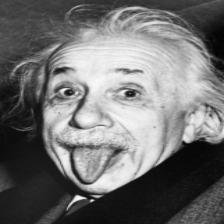

In [142]:
img = Image.open('./images/test_images_crop224_margin80/Einstein.jpg').convert('RGB')
img

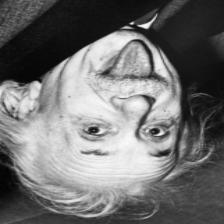

In [143]:
distort_image(img, "invert")

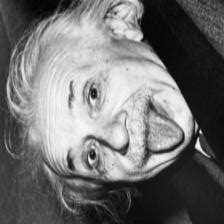

In [144]:
distort_image(img, "rot90")

15


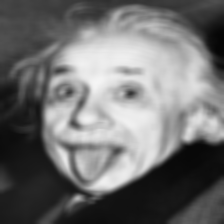

In [154]:
distort_image(img, "blur15")

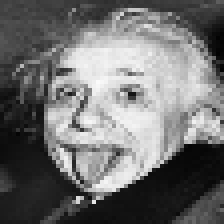

In [159]:
distort_image(img, "downscale")

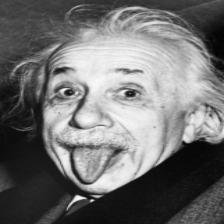

In [162]:
# nothing happens because this is grayscale!
distort_image(img, "channel_shuffle")

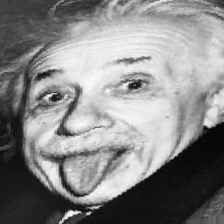

In [223]:
# elastic does a "random stretch" each time; we can control the randomness (for reproducability), by setting a seed
distort_image(img, "elastic", seed=6)

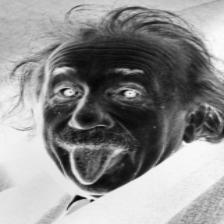

In [221]:
distort_image(img, "color_invert")

## ignore here down...will modify shuffle grid to be reproducible

In [233]:
AUG.RandomGridShuffle??

In [251]:
aug = AUG.RandomGridShuffle(grid=(10,10), always_apply=True, p=1.0)
aug

RandomGridShuffle(always_apply=True, p=1.0, grid=(10, 10))

In [252]:
tiles = aug.get_params_dependent_on_targets(dict(image=np.array(img)))


In [253]:
img2 = AF.swap_tiles_on_image(np.array(img), tiles['tiles'])
img2.shape

(224, 224, 3)

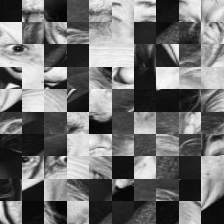

In [250]:
Image.fromarray(img2)